In [26]:
import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
df = pd.read_csv('../test/batches/batch_000.csv')

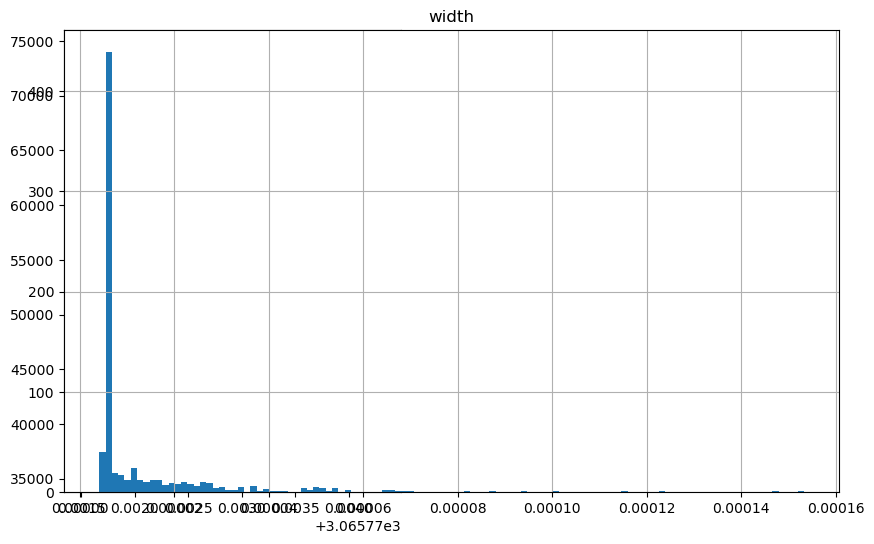

In [28]:
ax = plt.subplot()
df.hist('width', bins = 'auto', ax=ax)
# plt.yscale('log')
plt.show()

In [33]:
df['flags'].value_counts(dropna=False)

flags
NaN             571
nan fits: 1      23
nan fits: 12     21
nan fits: 13     21
nan fits: 9      20
nan fits: 10     18
nan fits: 2      16
nan fits: 11     16
nan fits: 8       6
nan fits: 4       5
nan fits: 3       4
nan fits: 5       4
nan fits: 6       3
nan fits: 14      2
nan fits: 15      2
Name: count, dtype: int64

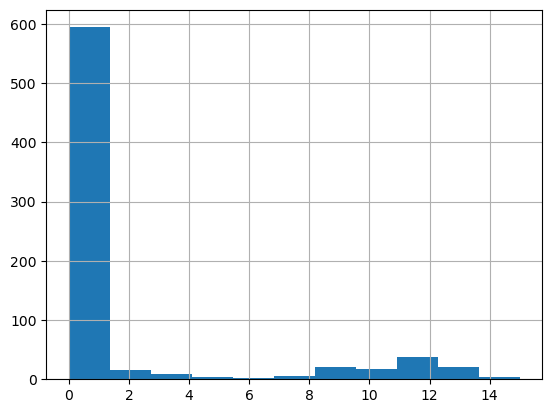

In [46]:
df['flags'].str.extract(r'nan fits: (\d+)')[0].fillna('0').astype(int).hist(bins='auto')
# plt.yscale('log')
plt.show()

In [47]:
import hdf5plugin
import h5py

f = h5py.File('/home/andres/breakthrough-listen/data/blc40_guppi_59358_40991_HIP3740_0031.rawspec.0000.h5')
data: h5py.Dataset = f['data'] #type: ignore

In [48]:
bad_hit = df.loc[625]
l_idx = bad_hit.frequency_index

In [17]:
bad_data = data[:, 0, l_idx : l_idx+1024]

foff: float = data.attrs['foff'] #type: ignore
fch1: float = data.attrs['fch1'] #type: ignore
freq_array = np.linspace(
    fch1 + foff * l_idx,
    fch1 + foff * (l_idx + 1024),
    num=bad_data.shape[1]
) #type: ignore

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# import re
# m = re.search(
#     r"fit error OptimizeWarning\('Covariance of the parameters could not be estimated', 'time slice index: (\d+)'\)",
#     bad_hit['flags']
# )
# if m:
#     bad_slice_idx = int(m.group(1))
#     print(bad_slice_idx)
# else:
#     raise ValueError(f'Could not get time slice. {bad_hit['flags'] = }')
y_vals = bad_data[15, :]
# y_vals[y_vals.argmax()] = (y_vals[y_vals.argmax() - 1] + y_vals[y_vals.argmax() + 1])/2

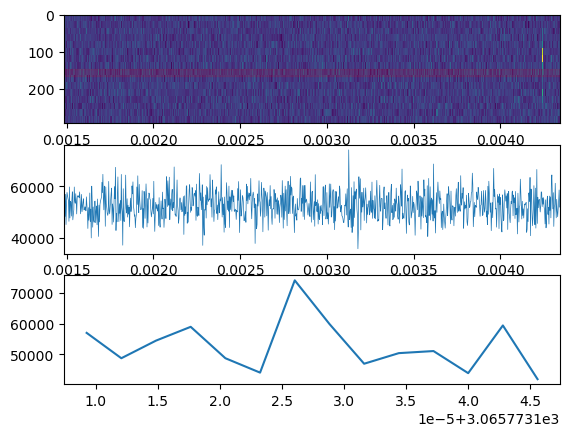

In [20]:
fig = plt.figure()

ax = fig.add_subplot(311)
ax.imshow(
    bad_data,
    extent=(
        freq_array[0], freq_array[-1],
        0, data.attrs['tsamp'] * bad_data.shape[0]
    ),
    aspect='auto',
    interpolation='none'
    # norm='log'
)
ax.axhspan(
    8 * data.attrs['tsamp'],
    (8 + 1) * data.attrs['tsamp'],
    color = 'red', alpha = 0.1)
ax.invert_xaxis()
ax.invert_yaxis()

slice_ax = fig.add_subplot(312, sharex=ax)
slice_ax.plot(freq_array, y_vals, lw = 0.5)

max_arg = y_vals.argmax()
width = 7
zoom_ax = fig.add_subplot(313)
zoom_ax.plot(freq_array[max_arg-width : max_arg+width], y_vals[max_arg-width : max_arg+width])

plt.show()

In [21]:
bad_hit.snr

np.float64(1.0438787765410444)

In [22]:
import scipy.optimize
import warnings

def signal_model(x, mean, stdev, amp, noise):
    exponent = -0.5 * ((x - mean)/stdev)**2
    return noise + amp * np.exp(exponent)

params, covt = scipy.optimize.curve_fit(
    signal_model, 
    freq_array, 
    y_vals, 
    p0=[
        freq_array[np.argmax(y_vals)], 
        np.abs(foff),
        np.max(y_vals) - np.median(y_vals),
        np.median(y_vals)
    ],
    # slow, screws up scale for some signals
    bounds=np.array([
        (freq_array[-1], freq_array[0]),
        (0, np.inf),
        (np.median(y_vals)/2, np.inf),
        (0, np.inf)
    ]).T,
    max_nfev=10_000
)

ValueError: Initial guess is outside of provided bounds

In [23]:
fig = plt.figure(figsize=(10, 6))

slice_ax = fig.add_subplot(121)
slice_ax.plot(freq_array, y_vals)
slice_ax.plot(freq_array, signal_model(freq_array, *params))
slice_ax.invert_xaxis()

max_arg = y_vals.argmax()
width = 7
zoom_ax = fig.add_subplot(122)
zoom_ax.plot(freq_array[max_arg-width : max_arg+width], y_vals[max_arg-width : max_arg+width])
zoom_ax.plot(freq_array[max_arg-width : max_arg+width], signal_model(freq_array, *params)[max_arg-width : max_arg+width])

plt.show()

NameError: name 'params' is not defined

In [ ]:
spike_idx = np.argmax(y_vals)
width = 5_000_000

view_vals = np.mean(f['data'][:, 0, l_idx+spike_idx-width : l_idx+spike_idx+width], axis = 0)

In [ ]:
plt.xlim(0, 2*(l_idx+spike_idx))
plt.plot(f['data'][bad_slice_idx, 0, :])
plt.axvline((l_idx+spike_idx), alpha=0.1)
plt.yscale('log')
plt.show()

In [ ]:
(l_idx + spike_idx) % (1048576//2)

np.int64(0)

In [25]:
df['snr']

0       1.770909
1       1.768067
2      55.199091
3      54.343181
4       4.439049
         ...    
727     5.615453
728     5.592953
729     2.652116
730     1.193984
731     1.205457
Name: snr, Length: 732, dtype: float64